# Darknet cifar10 (fastai v1)

In [2]:
%matplotlib inline

from fastai import *
from fastai.vision import *

import matplotlib.pyplot as plt
torch.cuda.set_device(0)
PATH = "/home/sairahul/myfiles/fastai_cmd/datasets/cifar10"
from fastai.vision.models.wrn import wrn_22

In [3]:
def conv_layer(ni, nf, ks=3, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding=ks//2),
        nn.BatchNorm2d(nf, momentum=0.01),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)
   ) 

In [4]:
class ResLayer(nn.Module):
    def __init__(self, ni):
        super().__init__()
        self.conv1 = conv_layer(ni, ni//2, ks=1)
        self.conv2 = conv_layer(ni//2, ni, ks=3)
    
    def forward(self, x):
        return x.add(self.conv2(self.conv1(x)))

In [5]:
class Darknet(nn.Module):
    def make_group_layer(self, ch_in, num_blocks, stride=1):
        return [conv_layer(ch_in, ch_in*2, stride=stride)
               ] + [(ResLayer(ch_in*2)) for i in range(num_blocks)]
    
    def __init__(self, num_blocks, num_classes, nf=32):
        super().__init__()
        layers = [conv_layer(3, nf, ks=3, stride=1)]
        for i, nb in enumerate(num_blocks):
            layers += self.make_group_layer(nf, nb, stride=2-(i==1))
            nf *= 2
        
        layers += [nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(nf, num_classes)]
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

In [6]:
m = Darknet([1, 2, 4, 6, 3], num_classes=10, nf=32)
#m = nn.DataParallel(m, device_ids=None)

In [7]:
PATH = "/home/sairahul/myfiles/fastai_cmd/datasets/cifar10"
bs=256
ds_tfms = ([*rand_pad(4, 32), flip_lr(p=0.5)], [])
data = (ImageDataBunch.from_folder(path=PATH, ds_tfms=ds_tfms, valid='test')
                     .normalize(imagenet_stats))

In [8]:
learn = Learner(data, m)
learn.init(nn.init.kaiming_normal_)
learn.loss_func = nn.CrossEntropyLoss()
learn.metrics = [accuracy]
wd = 1e-4
lr = 1.3
learn.opt_func = partial(optim.SGD, momentum=0.9)

In [9]:
learn.fit_one_cycle(cyc_len=30, max_lr=lr, wd=wd, div_factor=20., pct_start=0.8, moms=(0.95, 0.85))

epoch,train_loss,valid_loss,accuracy,time
0,1.922441,2.118107,0.235800,01:24
1,1.634747,1.758646,0.350500,01:24
2,1.459463,1.514455,0.457500,01:24
3,1.270517,2.195460,0.412100,01:24
4,1.106496,1.471370,0.533300,01:24
5,0.999286,1.284302,0.590600,01:24
6,0.875626,0.856789,0.703400,01:25
7,0.791008,0.990312,0.673300,01:24
8,0.774778,1.235535,0.642300,01:24
9,0.709334,0.735901,0.756000,01:24


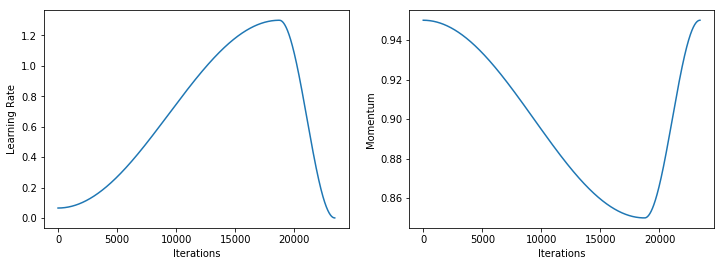

In [10]:
learn.recorder.plot_lr(show_moms=True)

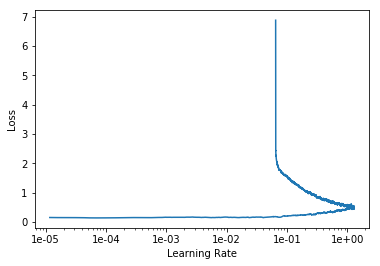

In [11]:
learn.recorder.plot()

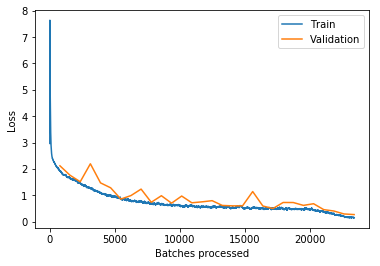

In [12]:
learn.recorder.plot_losses()

In [14]:
learn.fit_one_cycle(cyc_len=10, max_lr=0.2, wd=wd, div_factor=20., pct_start=0.8, moms=(0.95, 0.85))

epoch,train_loss,valid_loss,accuracy,time
0,0.190486,0.268978,0.910300,01:23
1,0.173402,0.263346,0.915200,01:23
2,0.154760,0.263701,0.913900,01:24
3,0.160246,0.272364,0.912700,01:24
4,0.147629,0.272216,0.914800,01:24
5,0.145718,0.292833,0.909900,01:24
6,0.129785,0.287203,0.912000,01:24
7,0.133280,0.281634,0.911800,01:24
8,0.117075,0.277301,0.915400,01:23
9,0.085638,0.264217,0.923100,01:24


In [15]:
learn.fit_one_cycle(cyc_len=3, max_lr=0.01, wd=wd, div_factor=20., pct_start=0.8, moms=(0.95, 0.85))

epoch,train_loss,valid_loss,accuracy,time
0,0.083953,0.262636,0.923600,01:23
1,0.081899,0.261727,0.925300,01:24
2,0.077172,0.263691,0.924800,01:23


In [ ]:
learn.fit_one_cycle(cyc_len=3, max_lr=1, wd=wd, div_factor=20., pct_start=0.5, moms=(0.95, 0.85))

epoch,train_loss,valid_loss,accuracy,time
0,0.320083,0.613349,0.825700,01:23
1,0.362744,0.598945,0.806500,01:24


In [2]:
#wide resnet 
ds_tfms = ([*rand_pad(4, 32), flip_lr(p=0.5)], [])
data = ImageDataBunch.from_folder(PATH, valid='test', ds_tfms=ds_tfms, bs=512).normalize(cifar_stats)
learn = Learner(data, wrn_22(), metrics=accuracy)
learn.to_fp16()
learn.fit_one_cycle(35, 3e-3, wd=0.4)

epoch,train_loss,valid_loss,accuracy,time
0,1.680056,1.476363,0.464100,01:00
1,1.311720,1.281948,0.551300,01:00
2,1.065065,1.281919,0.551100,01:00
3,0.890019,0.999144,0.650700,01:00
4,0.752760,1.296449,0.612100,01:00
5,0.649579,0.937407,0.685200,01:00
6,0.592696,0.761872,0.751900,01:00
7,0.539095,0.839040,0.725200,01:00
8,0.492565,0.587545,0.797800,01:00
9,0.450327,0.682603,0.768000,01:00
